# Using Persistent Cup Products for Dissonance Detection

### MSRI-UP 2023

Authors: Kimberly Herrera, Martin Martinez, Austin MBaye 

Date: 07/21/2023

In [67]:
#import important libraries 
import time
import wave
import pyaudio
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from matplotlib import pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from sklearn.cluster import KMeans
import tadasets
from itertools import combinations
from scipy.fft import fft, fftfreq, fftshift
from IPython.display import display, Audio, FileLink
%matplotlib inline

### Goal
We want to take a time series $f$, and detect any quasiperiodic behavior. To do this, we present the following algorithm that takes the two highest points in $H_1$ in the persistence diagram of the Rips filtration on the sliding window point cloud of $f$, takes the cup product between them, and plots the product on the diagram. Should this new point be highly persistent, then the time series is quasiperiodic. The motivation behind this is that quasiperiodic functions produce point clouds that are dense in tori, so we want their persistence diagram to "match" that of a torus with the addition of the cup product to confirm that the function has the correct structure.

We will apply this algorithm on music to detect dissonance. This will work because when you have dissonance, the frequencies of the music notes are linearly independent of each other so you get a quasiperiodic signal.

#### For the next cell, put your volume up!

In [68]:
display(FileLink('C:/Users/kimbe/Downloads/0_noise.wav', result_html_prefix="Click here to download: 0_noise.wav"))

C:\Users\kimbe\Downloads\0_noise.wav

In [69]:
# Open the WAV file
wav_file = wave.open('C:/Users/kimbe/Downloads/0_noise.wav', 'rb') #replace with the path on your machine

# Create an instance of the PyAudio class
audio_player = pyaudio.PyAudio()

# Open a stream to play the audio
stream = audio_player.open(format=audio_player.get_format_from_width(wav_file.getsampwidth()),
                           channels=wav_file.getnchannels(),
                           rate=wav_file.getframerate(),
                           output=True)

# Read the audio data in chunks and play it
chunk_size = 1024
data = wav_file.readframes(chunk_size)

while data:
    stream.write(data)
    data = wav_file.readframes(chunk_size)

# Stop and close the stream
stream.stop_stream()
stream.close()

# Terminate PyAudio
audio_player.terminate()

# Close the WAV file
wav_file.close()

In [70]:
file_path = 'C:/Users/kimbe/Downloads/0_noise.wav' #replace with the path on your machine
sample_rate, audio_data = wavfile.read(file_path)

# Define start and end times (in seconds)
start_time = 0.0
end_time = 0.1

# Convert the time values to corresponding sample indices
start_index = int(start_time * sample_rate)
end_index = int(end_time * sample_rate)

# Trim the audio data array
audio_data = audio_data[start_index:end_index]

# Convert stereo to mono
if audio_data.ndim > 1:
    audio_data = audio_data.mean(axis=1)
duration = (len(audio_data) / sample_rate) * 1000
real_time = np.linspace(0, duration, len(audio_data))

<ipython-input-70-6e4905643d09>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wavfile.read(file_path)


#### Now let's look at the formula for the time series of this sound!

There are two independent frequencies, 1046.502 Hz and 1479.98 Hz (where the second is an irrational multiple of the first).
We have:  <h3 align="center"> $ f(x) = \sin(1046.502 \cdot 2\pi \cdot x) + \sin(1046.502\sqrt2  \cdot 2\pi \cdot x)$ </h3>.

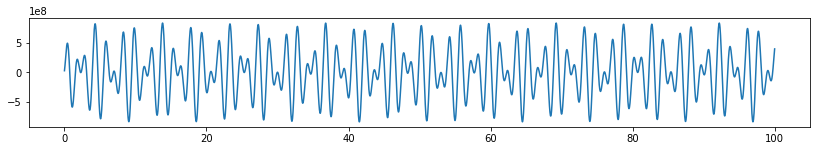

In [71]:
plt.figure(figsize = (14,2))
plt.plot(real_time, audio_data);

### Step 1: Function &#8594; Point Cloud
When applying sliding windows to a time series, a window of fixed size slides along the data, and the points within the window are collected to form a point cloud. The embedding dimension ($d$) refers to the number of dimensions/features used to represent each point in the sliding window. The time delay ($\tau$) specifies the time lag between the starting positions of adjacent windows. The delay can be thought of as the step size used to slide the window along the data. We want to optimize the values of $d$ and $\tau$ before applying sliding windows.

##### Finding $d$ : 
We want to compute a Fast Fourier Transform (FFT). This takes a series given by amplitude vs. time and returns it as amplitude vs. frequency, that way we can determine which frequency peaks in the time series are the strongest. The number of prominent peaks is what determines $d$.

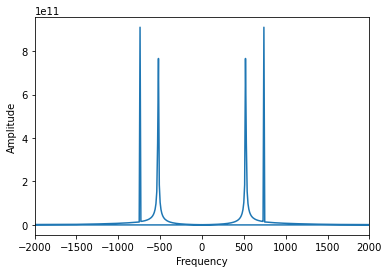

In [73]:
# Perform FFT
fft_result = np.fft.fft(audio_data)

# Compute the frequencies corresponding to the FFT result
sample_rate = 1 / (real_time[1] - real_time[0])  # Sampling rate
frequencies = np.fft.fftfreq(len(audio_data), 1 / sample_rate)

plt.plot(frequencies * 1000, np.abs(fft_result))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim([-2000, 2000])
plt.show()

How many peaks do you see? 

In [74]:
d = 4 #put the number of peaks here

In [75]:
unsorted_fft = []
for i in range(len(frequencies)):
    if i % 1000 == 0:
        print("on loop " + str(i) + " of " + str(len(frequencies)))
    if frequencies[i] * 1000 >= 0:
        pair = (frequencies[i] * 1000, np.abs(fft_result)[i])
        unsorted_fft.append(pair)
fft_array = sorted(unsorted_fft, key=lambda x: x[1], reverse=True) #find strongest frequency

on loop 0 of 4410
on loop 1000 of 4410
on loop 2000 of 4410
on loop 3000 of 4410
on loop 4000 of 4410


##### Finding $\tau$ :
We want a $\tau$ that miminizes the following equation:
 
$\displaystyle \Gamma(x) = \sum_{k \neq k'} \left\vert 1 + e^{ix \langle k - k', \omega \rangle} + \ldots + e^{ix \langle k - k', \omega \rangle d} \right\vert^2$.

This sums over every pair of distinct peaks, k and k' are the frequency values of the two distinct prominent peaks. 

In [76]:
prominent_peaks = []

for i in range(d):
    prominent_peaks.append(fft_array[i][0])

prominent_peaks

[739.8321995464853, 519.8820861678005, 529.8798185941043, 509.8843537414967]

In [77]:
def tau_sum(tau): #tau is x in the equation above
    '''Computes sum for prominent peaks given a value tau'''
    tau_sum = 0
    for i in range(len(prominent_peaks)):
        for j in range(i):
            re_sum = 1
            im_sum = 0
            for k in range(d + 1):
                re_sum += np.cos((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
                im_sum += np.sin((prominent_peaks[i] - prominent_peaks[j]) * tau * k)
            tau_sum += (re_sum ** 2) + (im_sum ** 2)
    return tau_sum

In [78]:
'''Check different values of tau and minimize'''
tau_vals = np.linspace(0, np.pi, 1000)

min_sum = 100000000000000000000
best_tau = None
for tau in tau_vals:
    if tau_sum(tau) < min_sum:
        min_sum = tau_sum(tau)
        best_tau = tau
        
print(best_tau)
print(min_sum)

0.5031579825569238
5.812843474105355


#### Now that we have all the optimal parameters, we can compute the sliding window point cloud:

In [79]:
def SW_cloud(f, tau, d, n_data):
    # Inputs:
    # f : time series -- array of size (2,N) (x and y values) or (1,N) (only y values)
    #For simplicity, we will assume that f, our time series is a nested list of two lists, each with x1, x2, ... xn and y1, y2,... and yn respectively.
    # tau: delay -- positive real number
    # d : gives embedding dimension d+1 -- integer
    # n_data : desired number of points in SW point cloud -- intenger
    #
    # Output:
    # SW : sliding window point cloud -- array of size (n_data,  d+1)

    #Step 1: turn f into a cubic spline
        x_vals = f[0]
        y_vals = f[1]
        cs = CubicSpline(x_vals, y_vals)


    #Step 2: create the t values where to evaluate SW_f
        t_vals = np.linspace(np.min(x_vals),np.max(x_vals)-d*tau,n_data)
 

    #Step 3: evaluate the sliding window point cloud
        SW=[]
        for t in t_vals:
            SW_f_t=cs(t + np.arange(0,d+1)*tau)
            SW.append(SW_f_t)
        SW=np.array(SW)

 

        return SW

In [80]:
f = np.array([real_time / 100000000, audio_data / 100000000])
d = d
tau = best_tau / 100000000
n_data = 1000
SW_f = SW_cloud(f, tau, d, n_data)

### Step 2: Point Cloud &#8594; Persistence Diagram via Ripser

Now that we have a point cloud, we want to compute a persistence diagram. The Ripser library we imported at the start does this for us, but let's go over what it does! 

First we need to compute a Rips filtration on the point cloud:
1. Compute the pairwise distance between all points in the cloud.
2. Pick a distance threshold $\alpha$ and connects points that are within $\alpha$ of each other. This creates new simplices for our simplicial complex.

 A simplicial complex K, is a set of sets such that (1) if $\sigma \in K$, then $0 < \#(\sigma) < \infty$ and (2) if $\sigma \in K$, and $\emptyset \ne \tau \subset \sigma$, then $\tau \in K$.
 
We continue increasing $\alpha$ until all points in our cloud are connected. As $\alpha$ increases, simplices of higher dimension are created such as triangles and tetrahedra. Once everything is connected, we're left with a simplicial complex!

Ripser then takes the simplicial complex and computes the barcode, which consists of intervals representing a topological feature in our data (connected component, hole, etc). The intervals indicate the birth and death of the features as the filtration progresses. The length of an interval represents the feature's persistence. Ripser first constructs the total boundary matrix from the simplicial complex and then reduces it to extract the barcode.

This is then visualized as:

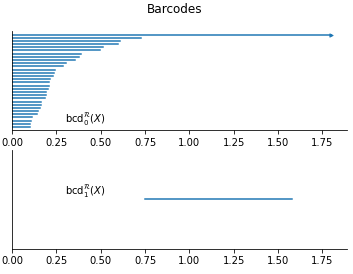

or as a persistence diagram:

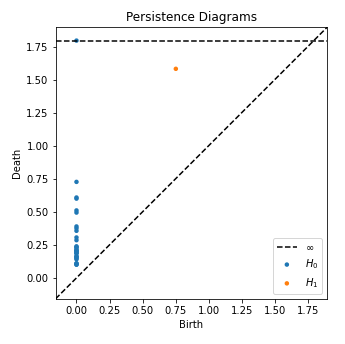

#### Now lets do this for our time series!

In [81]:
result = ripser(SW_f, coeff=2, do_cocycles=True) 
diagrams = result['dgms'] #get the persistence diagrams
dgm1 = diagrams[1] #persistence diagram for H^1
D = result['dperm2all'] #distance matrix

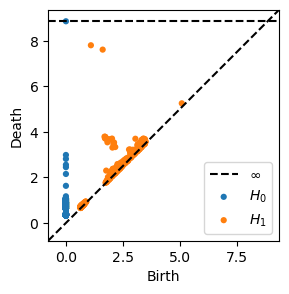

In [86]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,1)
plot_diagrams(diagrams)
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

No we want to extract all of the cocycles from the persistence diagram. Cocycles are defined:

$C^n(K; \mathbb{F}) = \{\varphi:K^{(n)} \rightarrow \mathbb{F} \;\; \textit{s.t.} \;\;\#(supp(\varphi)) < \infty\}$,  where $K is a simplicial complex.

These are in the kernel of $\delta^{n+1}$ but not in the image of $\delta^n$, where 

$\delta^n(\varphi)(\sigma) = \displaystyle\sum_{n=0}^{n+1}(-1)^j\varphi(\sigma - \{x_j\})$, 
for $\varphi \in C^n(K;\mathbb{F})$ and $\sigma \in K$.

In [87]:
cocycles = result['cocycles'] #all of the cocycles

### Step 3: Finding $\varphi$ and $\psi$

We now have a bunch of cocycles but we want the 2 most persistent ones. So we give our points in $H_1$ a persistence score:
$$\{b-a: (a, b) \in dgm_1\}$$ take the two points with the largest scores and find the cocycles that represent them.

In [88]:
#Representative cocycle phi
idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0]) #max persistence score
cocycle1 = cocycles[1][idx1] #get the cocycle with that score

In [89]:
#Representative cocycle psi
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0]) 
idx2 = sorted_indices[-2] #second max persistent score
cocycle2 = cocycles[1][idx2] #get the cocycle with that score

Now we need to restrict $\varphi$ (the more persistent one) to the simplices for which $\psi$ persists!

In [90]:
#Restrict cocycle1
New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])        
edges=np.vstack(edges)
for i in range(len(rcocycle1)):
    found_match = False
    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break
    if not found_match:
        rcocycle1[i, -1] = 0

KeyboardInterrupt: 

We also want the representative cocycles for the triangles in our simplicial complex, this is so that we can compute a cup product.

In [ ]:
# Finding the representative cocycles for triangles
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
triangles = []
for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    triangle_combinations = combinations(triangle_vertices, 3)
    for combination in triangle_combinations:
        triangles.append(list(combination))
t=np.vstack(triangles)

### Step 4: Taking the Cup Product

A cup product is a binary operation of cocycles defined
$$\varphi \cup \psi(\{x_0, ..., x_{n+m}\}) = \varphi(\{x_0, \ldots, x_n\} \cdot \psi(\{x_n , \ldots, x_m\})$$


with the following properties:
1. $\delta^{n + m}(\varphi \cup \psi) = \delta^n(\varphi) \cup \psi + (-1)^n \varphi \cup \delta^m(\psi)$
2. $[\varphi] \cup [\psi] = (-1)^{n \cdot m}[\psi] \cup [\varphi]$
3. $(\varphi + \varphi') \cup \psi = (\varphi \cup \psi) + (\varphi' \cup \psi)$
4. $\varphi \cup 0 = 0$


In [ ]:
def cupProduct(phi, psi, triangleList):
    '''Computes the cup product given two cocycles and a list of triangles'''
    cupProduct = []
    for i in range(len(triangleList)):
        phiVal = 0
        psiVal = 0
        for j in range(len(phi)):
            if phi[j][0] == triangleList[i][0] and phi[j][1] == triangleList[i][1]:
                phiVal = phi[j][2]
                break;
        for k in range(len(psi)):
            if psi[k][0] == triangleList[i][1] and psi[k][1] == triangleList[i][2]:
                psiVal = psi[k][2]
                break;
        cupProduct.append(phiVal * psiVal)
    cupProduct = np.array(cupProduct).T
    return cupProduct

In [ ]:
cup=cupProduct(rcocycle1,cocycle2, t) #Computes the cup Product
cup=np.vstack(cup)

YAY! We now have our cup product but to plot it on a persistence diagram we need both a birth and death. The birth is easy, we take the minimum of the births of $\varphi|_\alpha$ and $\psi$. The death, however, requires more work!

We need to find the solution to the following equation:

$$ \delta^1 \cdot x = \varphi |_\alpha \smile \psi$$

This will tell us for which triangle (x) the cup product becomes part of the 1-coboundary (and dies). We have the right side of the equation, now we need to compute $\delta^1$.

### Step 5: Computing the Coboundary Matrix $\delta^1$

First we need to know what are simplices are. We already have the triangles, so we need our vertices and edges.

In [ ]:
edges = []
vertices=[]
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
for cocycle in representative_cocycles: # Extracting every edge as an array of vertices
    edge_indices = cocycle[:, :2].astype(int)
    for i, j in edge_indices:
        edge = [i, j]
        edges.append(edge)
for cocycle in representative_cocycles: #Extracting every vertex
    vertex_indices = cocycle[:, :1].astype(int)
    for i in vertex_indices:
        vertices.append(i[0])
vertices = list(set(vertices)) # Remove duplicate vertices by converting the list to a set and then back to a list

Now we can compute the total boundary matrix.

In [ ]:
ne = len(edges)
nt = len(triangles)
nv = len(vertices)
num_rows= ne+nt+nv
num_cols=ne+nt+nv
boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)
for i,edge in enumerate(edges):
    a,b=edge #a and b are the two verticies that make up the edge
    for j,vertex in enumerate(vertices):
        c=vertex # c is a vertex
        if b == c:
            boundary_matrix[nv+i,j]=1
        if a == c:
            boundary_matrix[nv+i,j]=-1
for i, triangle in enumerate(triangles):
    e,f,g=triangle #e,f,g are verticies in the triangle
    for j,edge in enumerate(edges):
        h,k=edge 
        if (h,k) == (e,f):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (f,g):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (e,g):
            boundary_matrix[(ne+nv)+i,nv+j]=-1

We'll take the transpose and restrict the total boundary matrix so that we can get $\delta^1$.

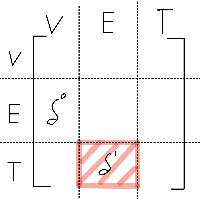

In [ ]:
boundary_matrix=boundary_matrix.T
#Convert Boundary Matrix into Coboundary
restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
coboundary_matrix = np.flip(restricted_matrix).T

### Step 5: Finding the Triangle

Now that we have both sides to our equation, we can solve for x. We will do this by taking the augmented matrix:
$$[\begin{array}{@{}c|c@{}}{\delta^1 } & {\varphi|_\alpha \smile \psi}\end{array}]$$
####### explain the bisection stuff

In [ ]:
def check_solution(A, b):
    """Calculates the rank of the augmented matrix [A | b]"""
    augmented_matrix = np.column_stack((A, b))
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)
    num_columns = A.shape[1]
    num_rows = A.shape[0]
    if rank_A == rank_augmented:
        if rank_A == num_columns:
            return 1
        elif rank_A < num_columns:
            return 1
    else:
        if rank_A < rank_augmented:
            return 0
    return "Unable to determine the solution status."

In [ ]:
def row_detect(A, b):
    """Finds the first row for which [A | b] has no solution"""
    i_max = len(A) + 1
    i_min = 1
    i = len(A) // 2
    running = True
    while running:
        sol = check_solution(A[-i:], b[-i:])
        if sol == 0:
            if check_solution(A[-(i - 1):], b[-(i - 1):]) == 1:
                row = len(A) - i
                running = False
                break;
            else:
                if i < i_max:
                    i_max = i
                    i = (i_max + i_min) // 2
        if sol == 1:
            if i > i_min:
                i_min = i
                i = (i_max + i_min) // 2
            if i == len(A):
                row = 0
                running = False
                break;
    return row

With these functions we can find the first row for which our matrix has no solution.

In [ ]:
detect=rowDetect(coboundary_matrix, cup)

Now that we have a row, we need the triangle corresponding to that row.

In [ ]:
def rowTriangle(r):
    value=len(triangles)-1-r
    return triangles[value]
    
tri=rowTriangle(detect)

 ### Step 6: Finding the $\alpha$ that births the triangle

We need to find the smallest $\alpha$ where triangle becomes part of $R_{\alpha}$. We'll do this by iterating over increasing values of $\alpha$ until the triangle is born in our simplicial complex. This will give us the death of the cup product.

In [ ]:
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx = sorted_indices[-2]
h = max(dgm1[idx, 0], dgm1[idx, 0])
while h < min(dgm1[idx, 1], dgm1[idx, 1]):
    newRun = ripser(x, coeff=2, thresh = h, do_cocycles = True)
    newDiagrams = newRun['dgms']
    newCocycles = newRun['cocycles']
    D = newRun['dperm2all']
    dgmNew = newDiagrams[1]
    new_representative_cocycles = []
    for i in range(len(dgmNew)):
        birth, death = dgmNew[i]
        if birth != death:  # ignore points on the diagonal
            newCocycle = newCocycles[1][i]
            new_representative_cocycles.append(newCocycle)
    newTriangles = []
    for newCocycle in new_representative_cocycles:
        edge_indices = newCocycle[:, :2].astype(int)
        new_triangle_vertices = set()
        for i, j in edge_indices:
            new_triangle_vertices.add(i)
            new_triangle_vertices.add(j)
        new_triangle_combinations = combinations(new_triangle_vertices, 3)
        for combination in new_triangle_combinations:
            newTriangles.append(list(combination))
    t=np.vstack(newTriangles)
    for k in range(len(t)):
        if t[k][0] == tri[0] and t[k][1] == tri[1] and t[k][2] == tri[2]:
            death=h #Gives the Cohomological death 
            h = 1000000
            break;
    h += 0.1

### Step 7: Plot the Cup Product

Now equipped with the birth and death of the cup product, we can plot it on the persistence diagram.

In [ ]:
#Part 4: Plot the persistence diagram with the new point
birth=dgm1[idx2,1] #death of psi but birth of H2 point 
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[0], dgm1[1], 20)
plt.scatter(death,birth, color='g')
plt.title("Peristence Diagram")
plt.show()